# Quickstart
* [tutorial](http://lightkurve.keplerscience.org/tutorials/1.02-target-pixel-files.html)

In [51]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
from astropy.io import fits
import pandas as pd

## How does the Vanderburg & Johnson 2014 K2SFF method work?

* [link](http://lightkurve.keplerscience.org/tutorials/motion-correction/replicate-vanderburg-2014-k2sff.html)

In [52]:
#k2sff lightcurve
vdb_fits = fits.open('hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits')

In [53]:
keys = ['MASKTYPE', 'MASKINDE', 'NPIXSAP']
_ = [print(key, ' : ', vdb_fits['BESTAPER'].header[key]) for key in keys]

MASKTYPE  :  PRF FIT
MASKINDE  :  4
NPIXSAP  :  29.0


Mask used in Vanderburg & Johnson (2014):

In [54]:
VDB_J_mask = vdb_fits['PRF_APER_TBL'].data[7,:, :] == True
VDB_J_mask.sum()

53

In [55]:
vdb_fits[2].columns

ColDefs(
    name = 'T'; format = 'D'
    name = 'FRAW'; format = 'D'
    name = 'FCOR'; format = 'D'
    name = 'ARCLENGTH'; format = 'D'
    name = 'MOVING'; format = 'I'
    name = 'CADENCENO'; format = 'J'
)

Diagnostic data

In [56]:
! wget https://www.cfa.harvard.edu/~avanderb/k2/ep60021426alldiagnostics.csv

--2018-03-29 22:26:02--  https://www.cfa.harvard.edu/~avanderb/k2/ep60021426alldiagnostics.csv
Resolving www.cfa.harvard.edu (www.cfa.harvard.edu)... 131.142.21.11
Connecting to www.cfa.harvard.edu (www.cfa.harvard.edu)|131.142.21.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33564 (33K) [text/plain]
Saving to: ‘ep60021426alldiagnostics.csv.7’

ep60021426alldiagno 100%[===================>]  32.78K  99.2KB/s    in 0.3s    

2018-03-29 22:26:03 (99.2 KB/s) - ‘ep60021426alldiagnostics.csv.7’ saved [33564/33564]



In [57]:
df = pd.read_csv('ep60021426alldiagnostics.csv',index_col=False)
df.head()

,BJD - 2454833,Raw Flux,Corrected Flux,X-centroid,Y-centroid,arclength,Correction,Thrusters On
0,1862.502368,0.995119,0.995985,25.135097,24.661074,2.327480,0.999130,1.0
1,1862.522801,0.997313,0.996767,25.289752,24.418689,1.175322,1.000548,1.0
2,1862.543235,0.996713,0.996136,25.288052,24.429406,1.214627,1.000580,0.0
3,1862.563668,0.996930,0.996277,25.275216,24.448405,1.306617,1.000656,0.0
4,1862.584102,0.996862,0.996228,25.253864,24.480184,1.460259,1.000636,0.0


In [58]:
df.columns

Index(['BJD - 2454833', ' Raw Flux', ' Corrected Flux', ' X-centroid',
       ' Y-centroid', ' arclength', ' Correction', ' Thrusters On'],
      dtype='object')

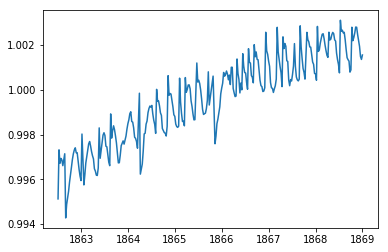

In [59]:
#Vanderburg-provided diagnostic data for the Kepler ENG testing
t = df['BJD - 2454833']
f = df[' Raw Flux']

pl.plot(t,f)

mean-subtract the provided x−y centroids, assigning them column and row identifiers, then rotate the coordinates into their major and minor axes

In [60]:
col = df[' X-centroid'].values
col = col - np.mean(col)
row = df[' Y-centroid'].values
row = row - np.mean(row)

In [61]:
def _get_eigen_vectors(centroid_col, centroid_row):
    '''get the eigenvalues and eigenvectors given centroid x, y positions'''
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [62]:
def _rotate(eig_vec, centroid_col, centroid_row):
    '''rotate the centroids into their predominant linear axis'''
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [63]:
eig_val, eig_vec = _get_eigen_vectors(col, row)
v1, v2 = eig_vec

In [64]:
platescale = 4.0 # The Kepler plate scale; has units of arcseconds / pixel

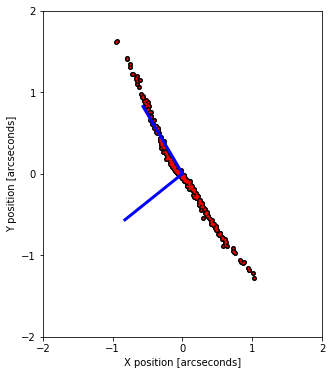

In [65]:
pl.figure(figsize=(5, 6))
pl.plot(col * platescale, row * platescale, 'ko', ms=4)
pl.plot(col * platescale, row * platescale, 'ro', ms=1)
pl.xticks([-2, -1,0, 1, 2])
pl.yticks([-2, -1,0, 1, 2])
pl.xlabel('X position [arcseconds]')
pl.ylabel('Y position [arcseconds]')
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
pl.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);

In [66]:
rot_colp, rot_rowp = _rotate(eig_vec, col, row) #units in pixels

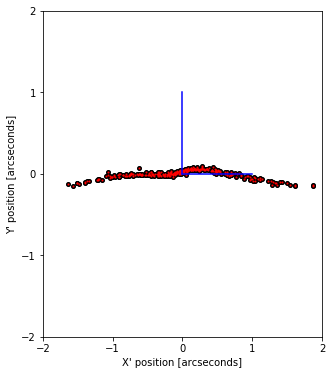

In [67]:
pl.figure(figsize=(5, 6))
pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ko', ms=4)
pl.plot(rot_rowp * platescale, rot_colp * platescale, 'ro', ms=1)
pl.xticks([-2, -1,0, 1, 2])
pl.yticks([-2, -1,0, 1, 2])
pl.xlabel("X' position [arcseconds]")
pl.ylabel("Y' position [arcseconds]")
pl.xlim(-2, 2)
pl.ylim(-2, 2)
pl.plot([0, 1], [0, 0], color='blue')
pl.plot([0, 0], [0, 1], color='blue');

Calculate arclength. Fit a 5th order polynomial to the rotated coordinates.

In [68]:
order=5
z = np.polyfit(rot_rowp, rot_colp, order)
p = np.poly1d(z)
p_deriv = p.deriv()

In [69]:
x0_prime = np.min(rot_rowp)
xmax_prime = np.max(rot_rowp)
x_dense = np.linspace(x0_prime, xmax_prime, 2000)

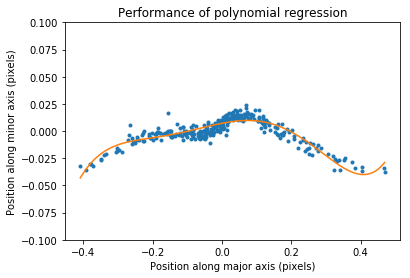

In [70]:
pl.plot(rot_rowp, rot_colp, '.')
pl.plot(x_dense, p(x_dense))
pl.ylabel('Position along minor axis (pixels)')
pl.xlabel('Position along major axis (pixels)')
pl.title('Performance of polynomial regression')
pl.ylim(-0.1, 0.1);

[Bias-Variance Tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

In [71]:
def arclength(x_prime, x_dense, p_deriv):
    '''Input x1_prime, get out arclength'''
        
    s = []
    for i in x_prime:
        gi = x_dense < i
        s_integrand = np.sqrt(1 + p_deriv(x_dense[gi]) ** 2)
        s.append(np.trapz(s_integrand, x=x_dense[gi]))
    return np.array(s)

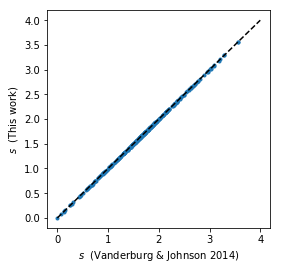

In [72]:
aspect_ratio = pl.figaspect(1)
pl.figure(figsize=aspect_ratio)

pl.plot(df[' arclength'], arclength(rot_rowp,x_dense,p_deriv)*4.0, '.')
pl.xlabel('$s$  (Vanderburg & Johnson 2014)')
pl.ylabel('$s$  (This work)')
pl.plot([0, 4], [0, 4], 'k--');

apply a high-pass filter to the raw lightcurve data. We follow the original paper by using BSplines with 1.5 day breakpoints. You can also apply data exclusion at this stage.

In [73]:
from scipy.interpolate import BSpline
from scipy import interpolate

times, raw_fluxes = df['BJD - 2454833'].values, df[' Raw Flux'].values

 find the weighted least square spline for a given set of knots, t. We supply interior knots as knots on the ends are added automatically, as stated in the interpolate.splrep() docstring.

In [74]:
interior_knots = np.arange(times[0]+1.5, times[0]+6, 1.5)
t,c,k = interpolate.splrep(times, raw_fluxes, s=0, task=-1, t=interior_knots)
bspl = BSpline(t,c,k)

In [75]:
interior_knots

array([1864.00236752, 1865.50236752, 1867.00236752])

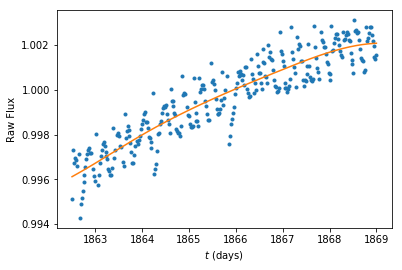

In [76]:
pl.plot(times, raw_fluxes, '.')
pl.plot(times, bspl(times))
pl.xlabel('$t$ (days)')
pl.ylabel('Raw Flux');

normalize the flux by the long-term trend.
Plot the normalized flux versus arclength to see the position-dependent flux.


In [77]:
fluxes = raw_fluxes/bspl(times)

Mask the data by keeping only the good samples.

In [78]:
bi = df[' Thrusters On'].values == 1.0
gi = df[' Thrusters On'].values == 0.0
clean_fluxes = fluxes[gi]
al = arclength(rot_rowp[gi],x_dense,p_deriv) * platescale

In [79]:
sorted_inds = np.argsort(al)

interpolating flux versus arclength position in 15 bins of means, which is a piecewise linear fit.

In [80]:
knots = np.array([np.min(al)]+
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], 15)]+
                 [np.max(al)])

In [81]:
bin_means = np.array([clean_fluxes[sorted_inds][0]]+
                     [np.mean(splt) for splt in np.array_split(clean_fluxes[sorted_inds], 15)]+
                     [clean_fluxes[sorted_inds][-1]])

In [82]:
zz = np.polyfit(al, clean_fluxes,6)
sff = np.poly1d(zz)
al_dense = np.linspace(0, 4, 1000)
interp_func = interpolate.interp1d(knots, bin_means)

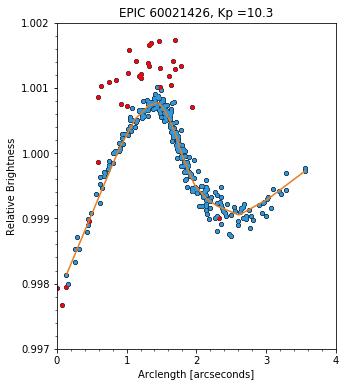

In [83]:
pl.figure(figsize=(5, 6))
pl.plot(arclength(rot_rowp,x_dense,p_deriv)*4.0, fluxes, 'ko', ms=4)
pl.plot(arclength(rot_rowp,x_dense,p_deriv)*4.0, fluxes, 'o', color='#3498db', ms=3)
pl.plot(arclength(rot_rowp[bi],x_dense,p_deriv)*4.0, fluxes[bi], 'o', color='r', ms=3)
pl.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')

pl.xticks([0, 1,2, 3, 4])
pl.minorticks_on()
pl.xlabel('Arclength [arcseconds]')
pl.ylabel('Relative Brightness')
pl.title('EPIC 60021426, Kp =10.3')
pl.xlim(0,4)
pl.ylim(0.997, 1.002);

Apply the Self Flat Field (SFF) correction:

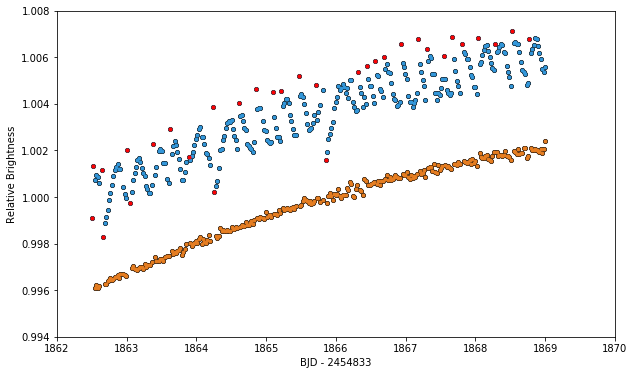

In [84]:
corr_fluxes = clean_fluxes / interp_func(al)

pl.figure(figsize=(10,6))

dy = 0.004
pl.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'ko', ms=4)
pl.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'o', color='#3498db', ms=3)
pl.plot(df['BJD - 2454833'][bi], df[' Raw Flux'][bi]+dy, 'o', color='r', ms=3)
pl.plot(df['BJD - 2454833'][gi], corr_fluxes*bspl(times[gi]), 'o', color='k', ms = 4)
pl.plot(df['BJD - 2454833'][gi], corr_fluxes*bspl(times[gi]), 'o', color='#e67e22', ms = 3)

pl.xlabel('BJD - 2454833')
pl.ylabel('Relative Brightness')

pl.xlim(1862, 1870)
pl.ylim(0.994, 1.008);

## Replicating Vanderburg & Johnson 2014 using lightkurve
* [link](http://lightkurve.keplerscience.org/tutorials/motion-correction/replicate-vanderburg-2014-lightkurve.html)

In [85]:
from lightkurve import KeplerTargetPixelFile
from lightkurve import SFFCorrector

pathname = 'https://archive.stsci.edu/pub/k2/eng/long_cadence/kplr060021426-2014044044430_lpd-targ.fits'
tpf = KeplerTargetPixelFile(pathname)

In [86]:
VDB_J_mask = np.load('VDB_J_2014_mask.npy')

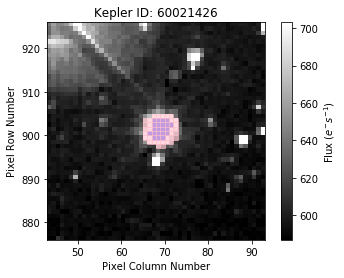

In [87]:
ax = tpf.plot(aperture_mask=tpf.pipeline_mask, mask_color='b', frame=300,
              scale='linear', cmap='gray',show_colorbar=False)
tpf.plot(aperture_mask=VDB_J_mask, frame=300, scale='linear', cmap='gray', ax=ax, mask_color='pink');

In [88]:
lc_raw = tpf.to_lightcurve(aperture_mask=VDB_J_mask)

Exlude the first 2.5 days and non-zero quality flags, following Vanderburg & Johnson.

In [89]:
first_2p5_days = lc_raw.time - lc_raw.time[0] < 2.5
nonzero_quality_flags = lc_raw.quality != 0

keep_indices = ~first_2p5_days & ~nonzero_quality_flags

In [90]:
lc_trim = lc_raw[keep_indices]
lc = lc_trim.normalize()

In [91]:
sff = SFFCorrector()

In [92]:
lc_corrected = sff.correct(lc.time, lc.flux, lc.centroid_col, lc.centroid_row,
                           niters=1, windows=1, polyorder=5)

100%|██████████| 1/1 [00:00<00:00, 25.15it/s]


In [93]:
long_term_trend = sff.trend

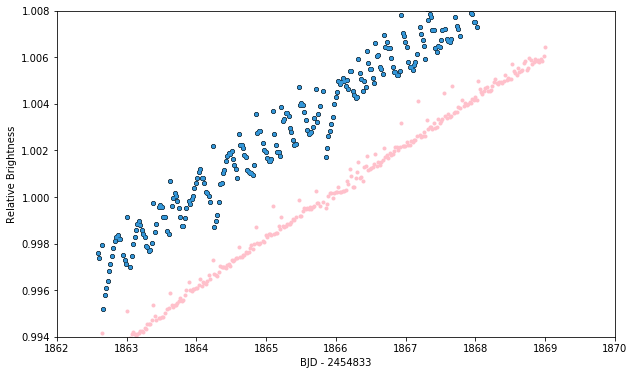

In [94]:
pl.figure(figsize=(10,6))

dy = 0.004
pl.plot(lc.time, lc.flux + dy, 'ko', ms=4)
pl.plot(lc.time, lc.flux+dy, 'o', color='#3498db', ms=3)
pl.plot(lc_corrected.time, lc_corrected.flux * long_term_trend, 'o', color='pink', ms = 3)

pl.xlabel('BJD - 2454833')
pl.ylabel('Relative Brightness')

pl.xlim(1862, 1870)
pl.ylim(0.994, 1.008);

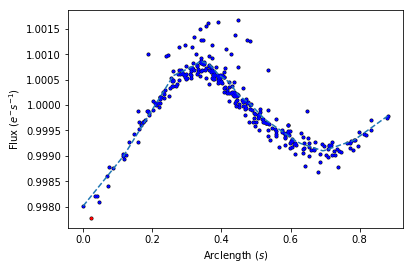

In [95]:
sff._plot_normflux_arclength();

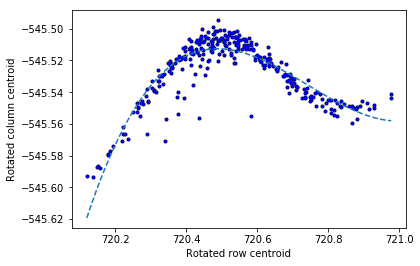

In [96]:
sff._plot_rotated_centroids();

## Function

## Using custom aperture